In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []
print("seed",seed)

print(datetime.datetime.now())

seed 1
2023-07-06 02:13:37.268460


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(-0.6219)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-8.9998)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(25312.2871)
train_loss:  -4.985803543844819
valid_loss:  127.67956665782928
h_min_tilde -6.162114 ell_tilde 21.54727049649 kappa_tilde 0.00018997067216942673
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -0.8838864429771901
valid_loss:  -0.9038935440540314
weight_alpha 1.0 h_min_tilde -6.162114 ell_tilde -0.8878878631925583 kappa_tilde 0.00043543227924951113


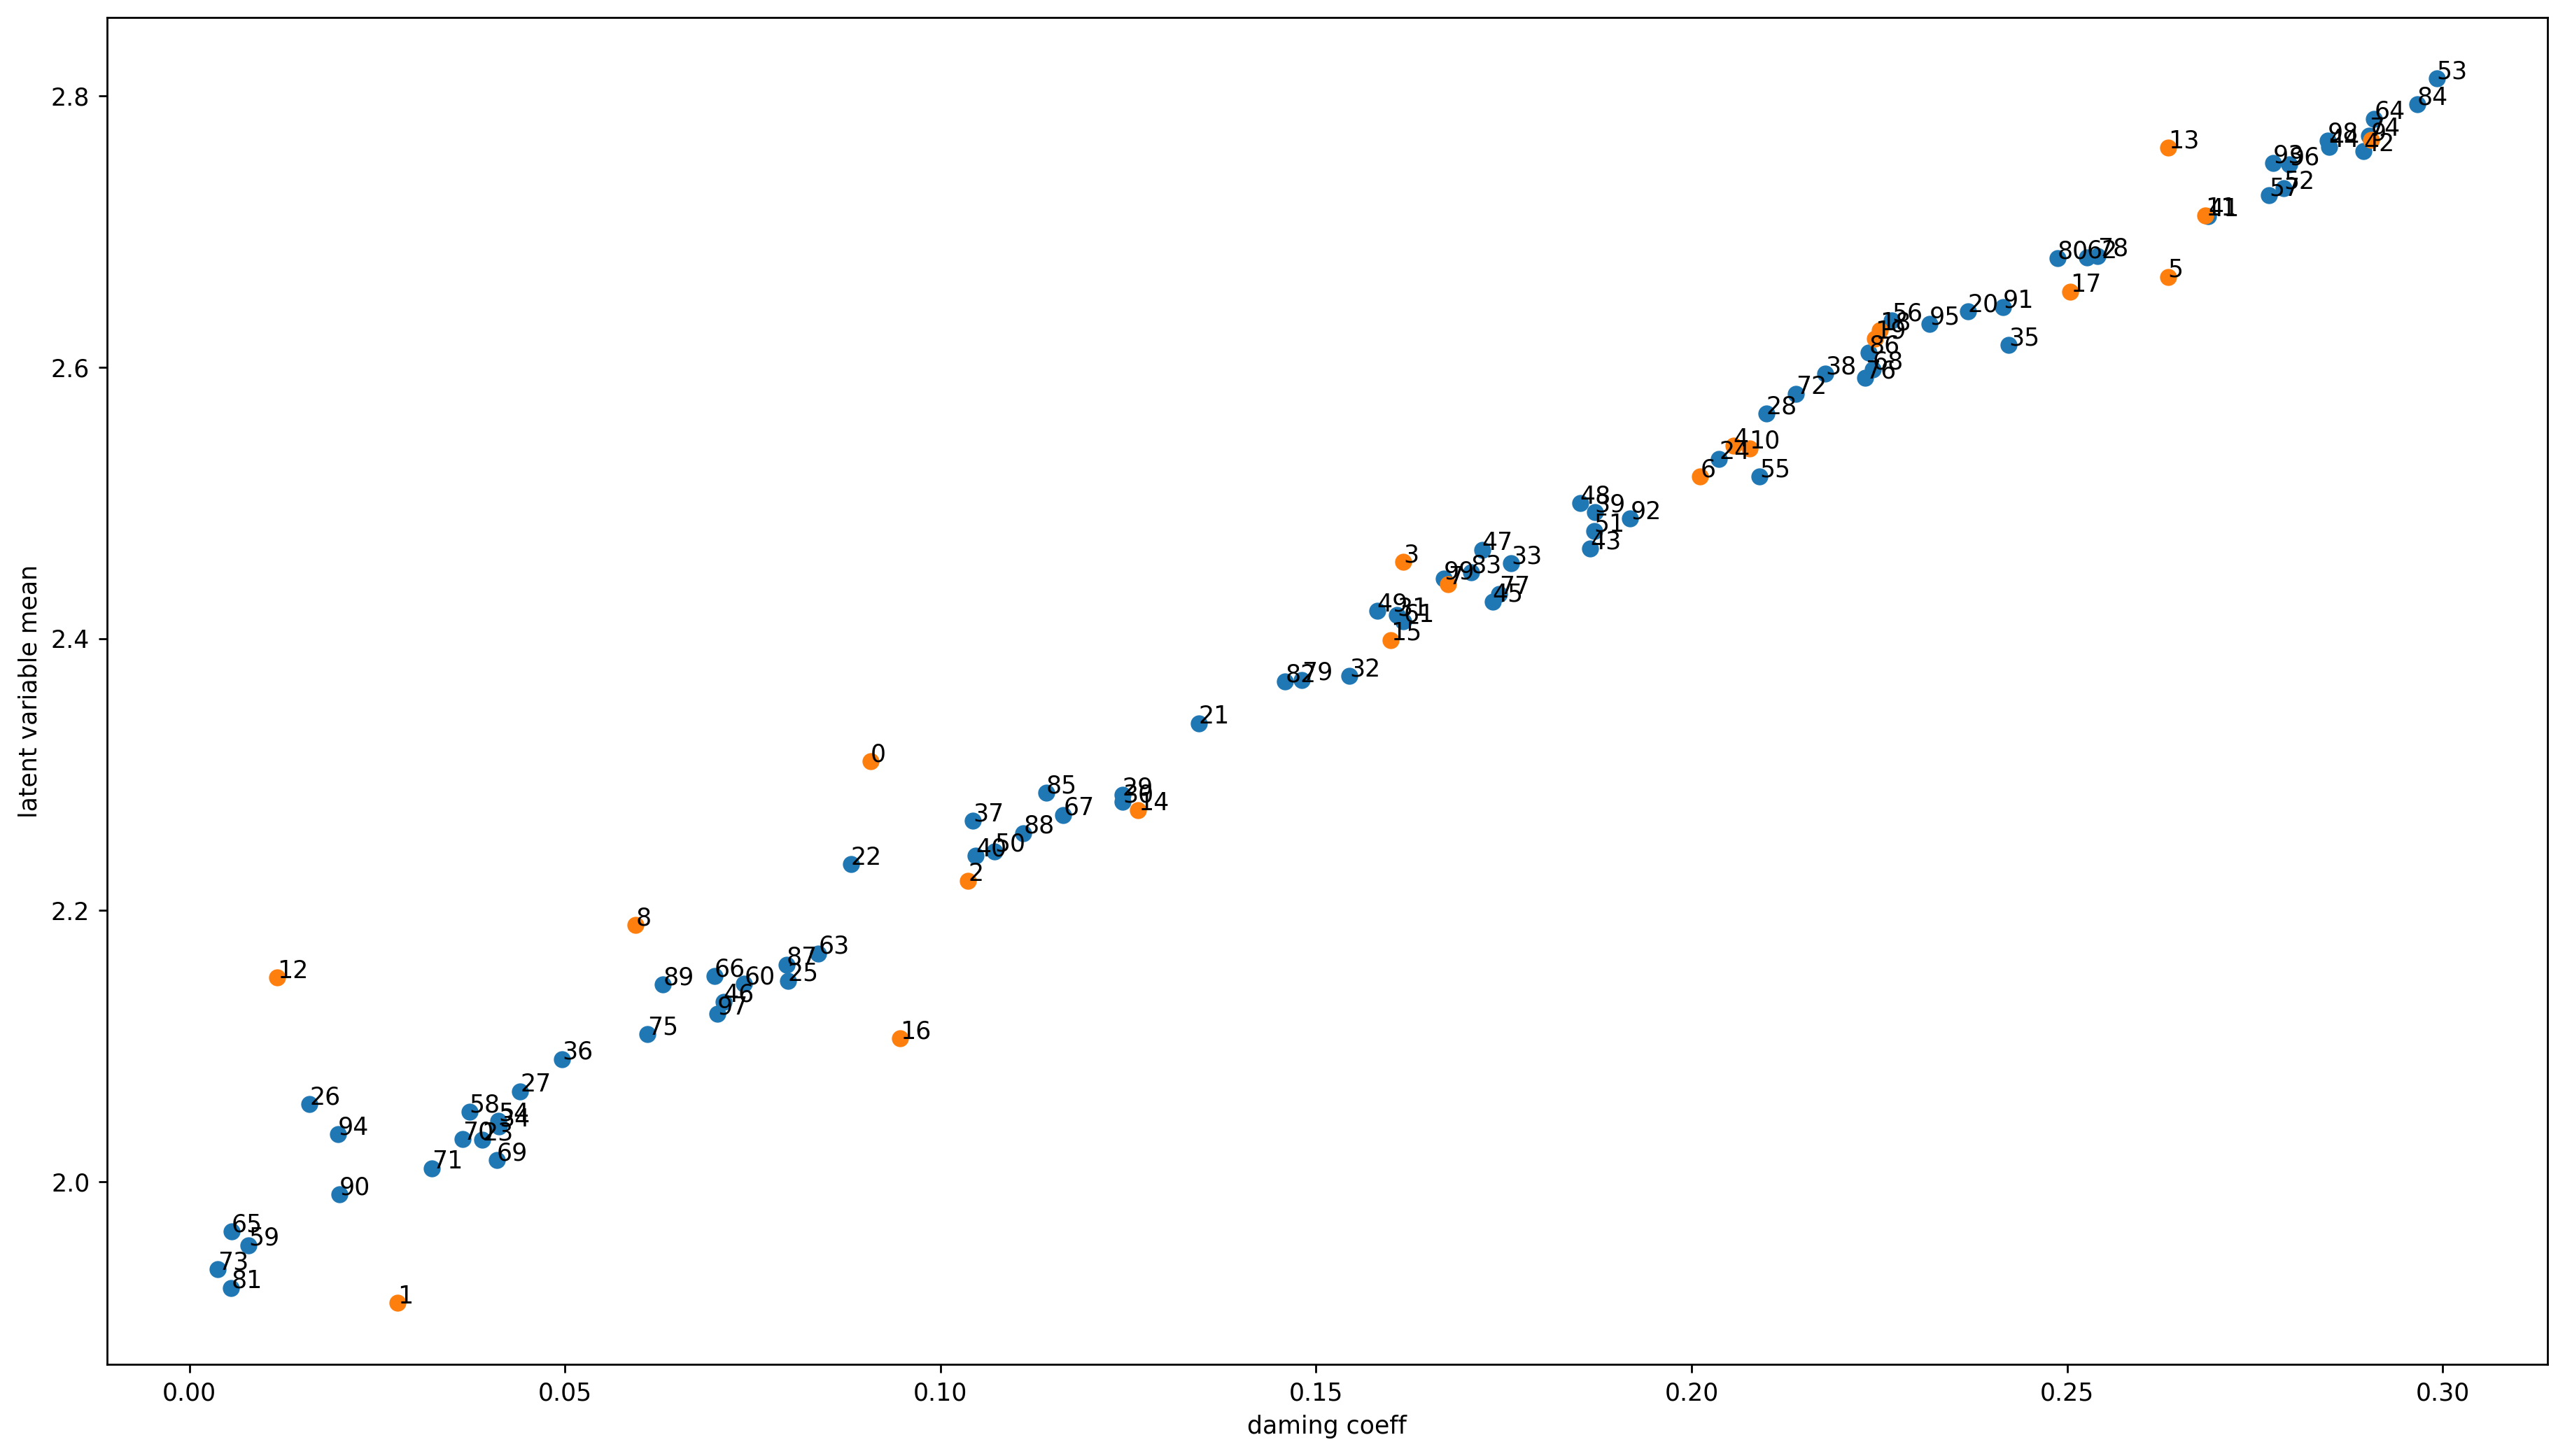

[0.09069977 0.02770158 0.10366822 0.16164502 0.20556585 0.26343523
 0.20114025 0.16760695 0.05943045 0.29047847]
[0.20769678 0.268382   0.01171643 0.26344275 0.12633229 0.15994959
 0.09465469 0.2503877  0.22504329 0.2244497 ]
[0.2367838  0.13436806 0.08808424 0.03900857 0.20365066 0.079664
 0.01600876 0.04401857 0.20992751 0.1242168 ]
[0.12425378 0.16076892 0.15446673 0.17596651 0.04124241 0.24221739
 0.04960626 0.10432976 0.2177994  0.18710166]
[0.1046695  0.26876587 0.28945201 0.18650872 0.28484678 0.17351688
 0.07110809 0.17210385 0.18514347 0.15811743]
[0.10718093 0.18700803 0.27883117 0.29919686 0.04114072 0.20904545
 0.22663892 0.27690736 0.03728129 0.0078633 ]
[0.07386332 0.16164932 0.25260927 0.0837551  0.29087872 0.00559419
 0.06989228 0.11635819 0.22413649 0.04093657]
[0.03640304 0.03224824 0.21389669 0.00376679 0.2901829  0.06098797
 0.22314776 0.17440768 0.25404864 0.14813091]
[0.24869427 0.00557286 0.14590353 0.17065543 0.29658485 0.11404235
 0.22360033 0.07947587 0.111025

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.4016971588134766

 2 3.9017999172210693

 3 7.060372591018677

 4 6.650329351425171

 5 6.430522918701172

 6 6.7844977378845215

 7 6.717043161392212

 8 6.82999062538147

 9 7.15694522857666

 10 6.898673057556152

 11 6.343648910522461

 12 3.625209331512451

 13 3.3634097576141357

 14 3.392932653427124

 15 3.269967555999756

 16 3.2664616107940674

 17 3.305929660797119

 18 3.2879626750946045

 19 3.428133726119995

 20 3.2367701530456543

 21 3.3177976608276367

 22 3.3246588706970215

 23 3.3826234340667725

 24 3.4043965339660645

 25 3.1942310333251953

 26 3.4264235496520996

 27 3.2368264198303223

 28 3.368497848510742

 29 3.3232743740081787

 30 3.322782278060913

 31 3.2573773860931396

 32 3.3907630443573

 33 3.28926944732666

 34 3.2695608139038086

 35 3.3554861545562744

 36 3.3338050842285156

 37 3.3559000492095947

 38 3.505174160003662

 39 3.2797231674194336

 40 3.4071264266967773

 41 3.5112364292144775

 42 3.377901792526245

 43 3.4049196243286133



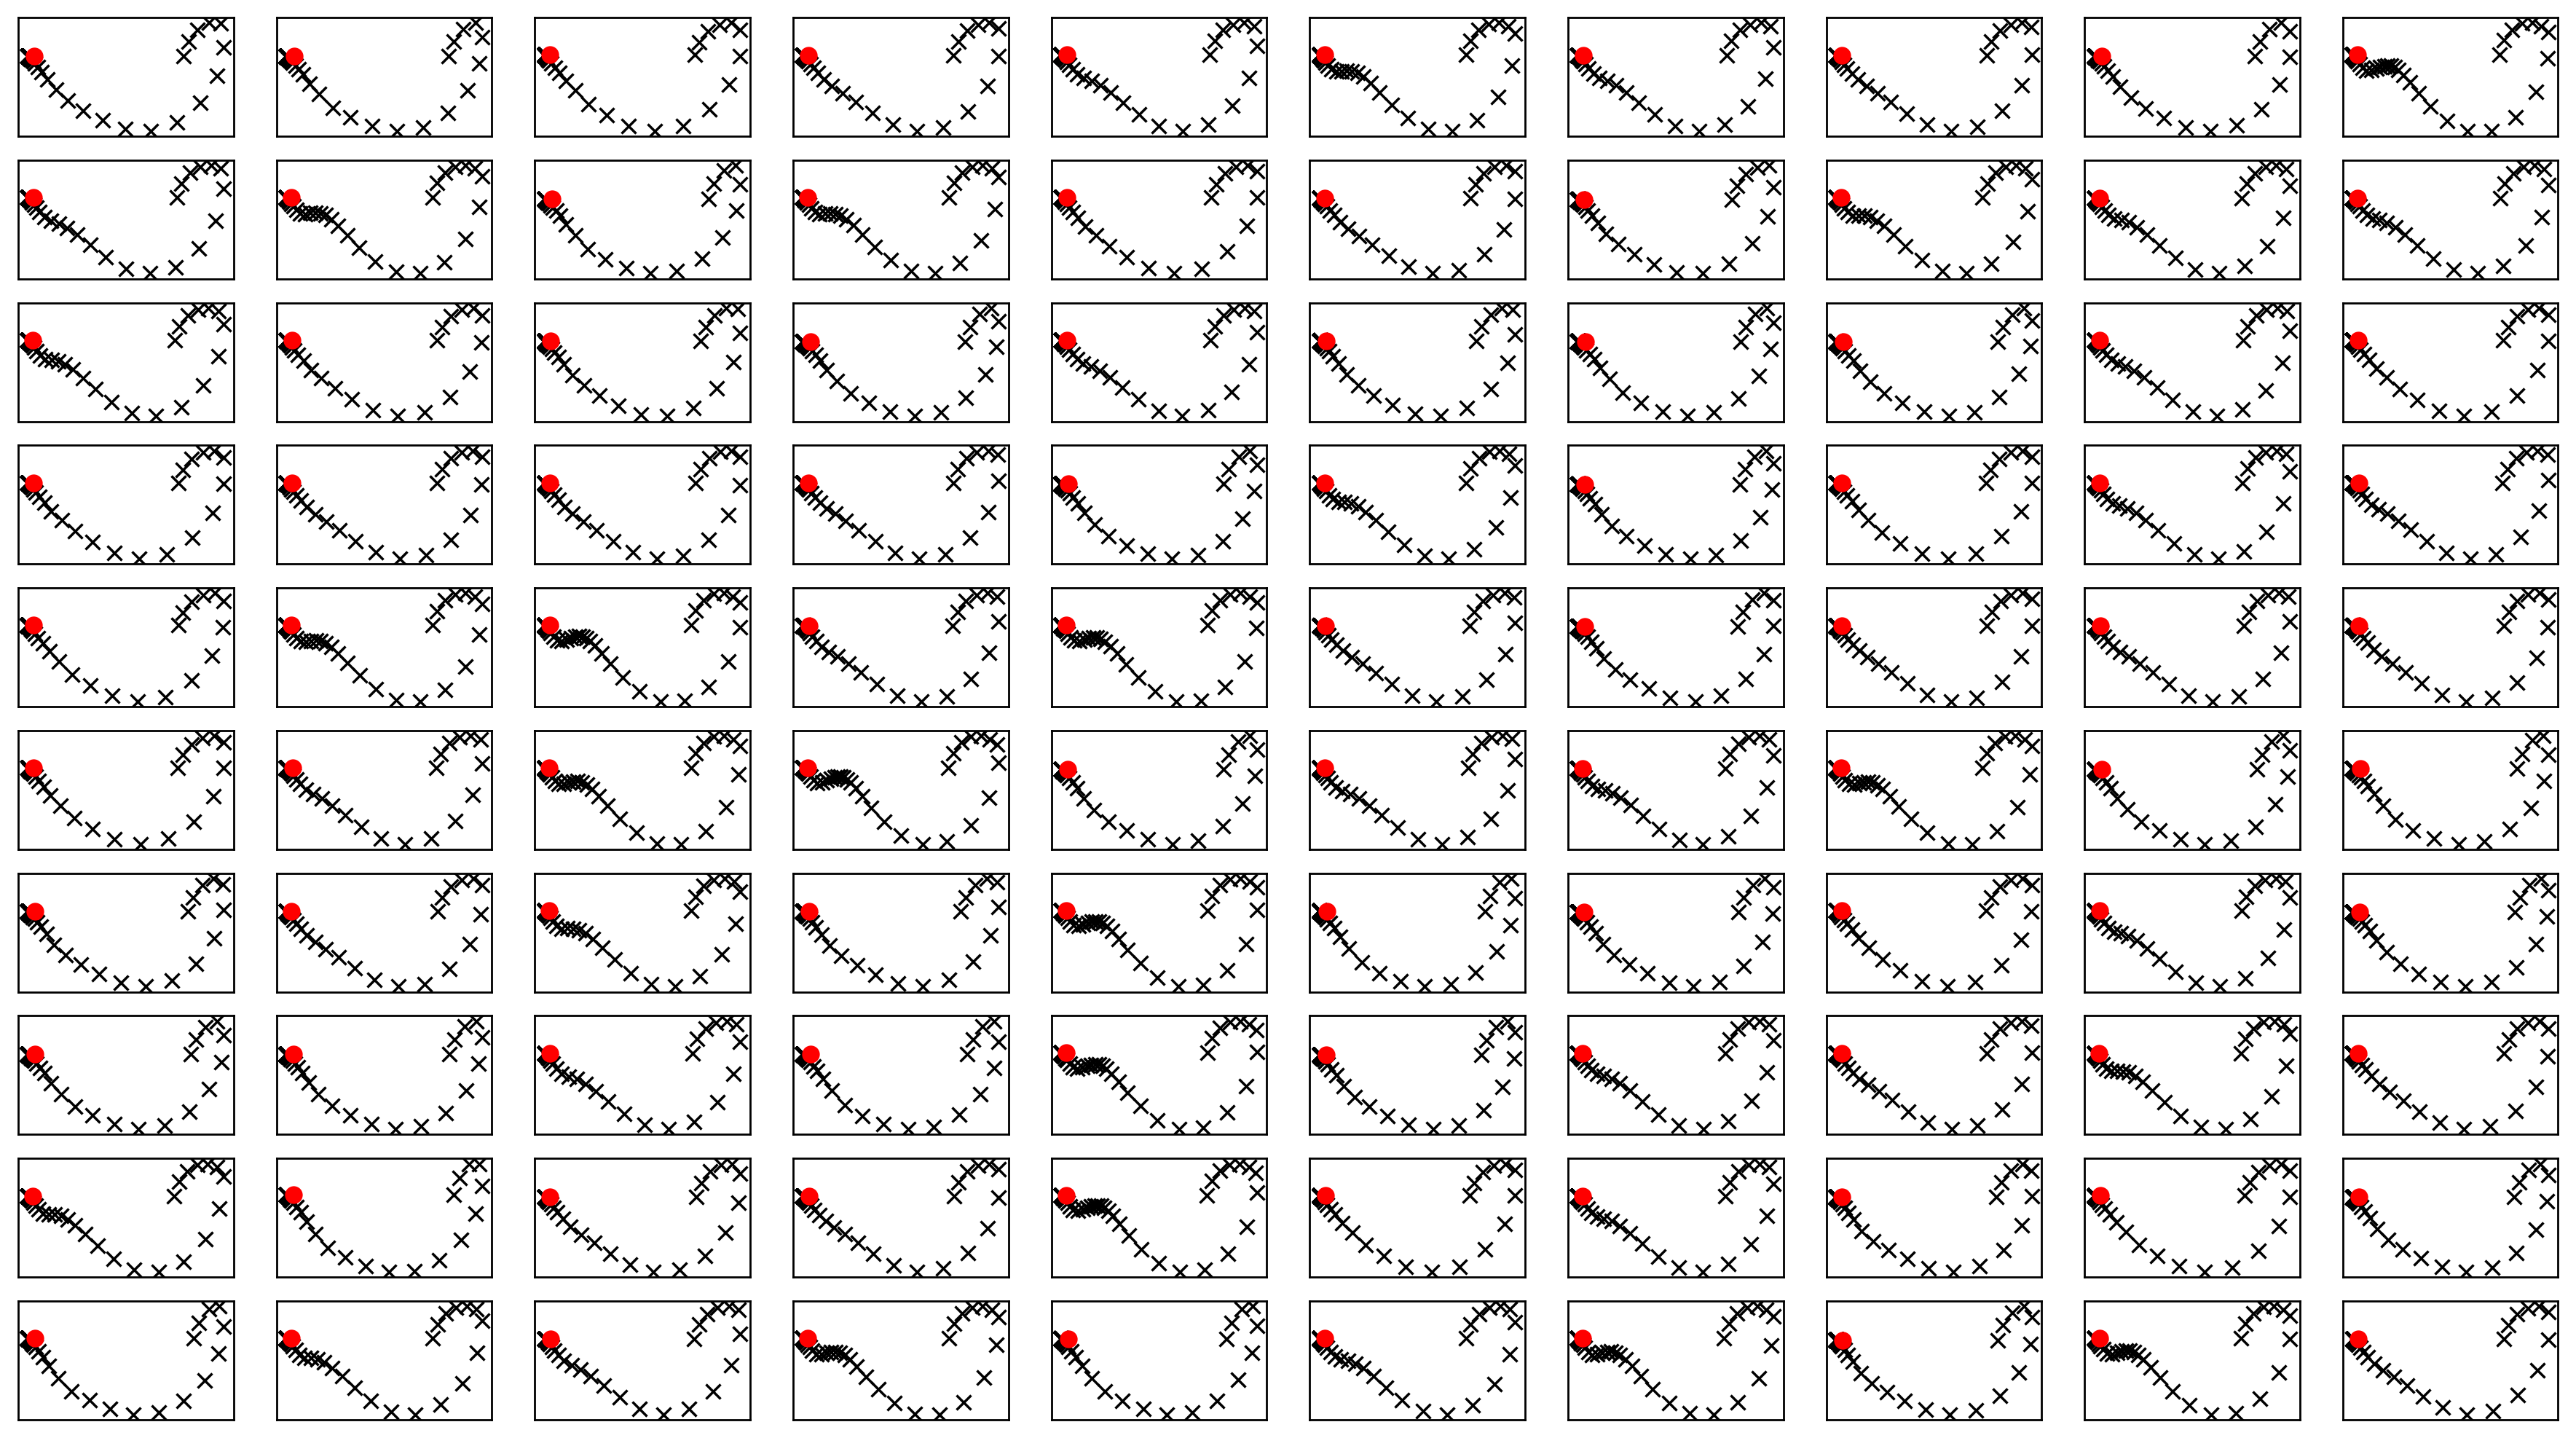

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 7.152557373046875e-07

 1 3.581043243408203

 2 3.354417085647583

 3 3.4056334495544434

 4 3.5019710063934326

 5 3.455854654312134

 6 3.4238009452819824

 7 3.4234609603881836

 8 3.43880033493042

 9 3.4139504432678223

 10 3.6153597831726074

 11 3.4143924713134766

 12 3.4074461460113525

 13 3.528373956680298

 14 3.445545196533203

 15 3.351003646850586

 16 3.4048912525177

 17 3.428952217102051

 18 3.359174966812134

 19 3.4080100059509277

 20 3.414658546447754

 21 3.4051077365875244

 22 3.3054251670837402

 23 3.35109543800354

 24 3.5331239700317383


In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())